# 🎬 TMDB Movie Dataset Analysis – Google Colab Version

Notebook ini secara otomatis mengunduh dua dataset dari Google Drive menggunakan `gdown`:

- `tmdb_5000_credits.csv`
- `tmdb_5000_movies.csv`

> ✅ Pastikan file di Google Drive sudah diatur ke "Anyone with the link can view".


In [6]:
# Install gdown
!pip install -q gdown

# Unduh file credits
!gdown --id 1orCVjye0zLpGySwoTYLBpD4nKdtitvwf -O tmdb_5000_credits.csv

# Unduh file movies
!gdown --id 1W9jWmq4cYmE7W6qBvPa7N9MXbAWQU2-3 -O tmdb_5000_movies.csv


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1orCVjye0zLpGySwoTYLBpD4nKdtitvwf
To: /content/tmdb_5000_credits.csv
100% 40.0M/40.0M [00:00<00:00, 88.6MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1W9jWmq4cYmE7W6qBvPa7N9MXbAWQU2-3
To: /content/tmdb_5000_movies.csv
100% 5.70M/5.70M [00:00<00:00, 227MB/s]


In [7]:
import pandas as pd

# Baca file CSV yang baru diunduh
credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")

# Tampilkan 5 baris pertama dari masing-masing dataset
print("🎥 Dataset: Credits")
print(credits.head())

print("\n🎬 Dataset: Movies")
print(movies.head())


🎥 Dataset: Credits
   movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479

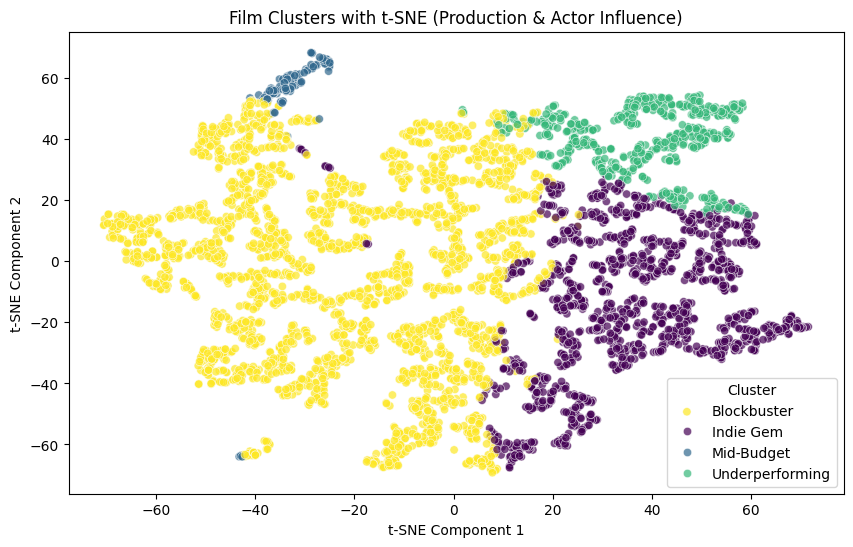

MSE: 0.3540198081031725
R-squared: 0.7484609344650807


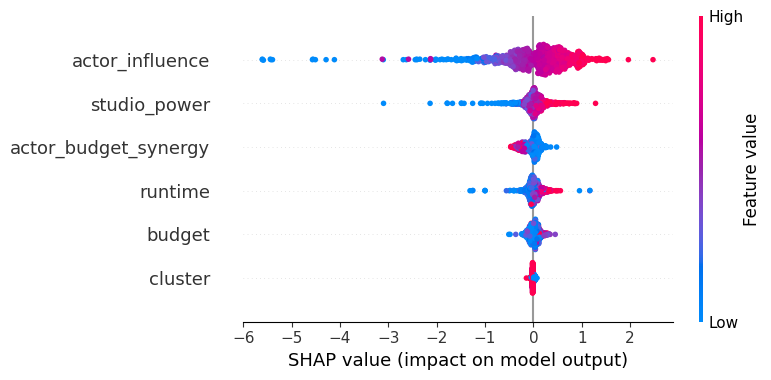

Model and scaler saved.


interactive(children=(FloatSlider(value=80000000.0, description='budget', max=380000000.0, step=1000000.0), In…

'\nstudio_power = rata-rata rating film yang diproduksi oleh studio terkait sebelumnya\nactor_influence = rata-rata rating film yang pernah dimainkan oleh aktor terkait sebelumnya\n'

In [8]:
# Revised Data Visualization of K-Means and Gradient Boosted Trees
# Analyzing Correlation Between Actors, Production, and Film Popularity

# Import libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib
import warnings
import ipywidgets as widgets
from IPython.display import display

# Suppress specific future warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="The PCA initialization in TSNE")

# Load datasets
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')

# Merge datasets
merged_df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')

# Extract top actors and main studio
def extract_top_actors(cast_str, top_n=3):
    try:
        cast = ast.literal_eval(cast_str)
        return [actor['name'] for actor in cast[:top_n]]
    except:
        return []

def extract_main_studio(production_str):
    try:
        companies = ast.literal_eval(production_str)
        return companies[0]['name'] if companies else None
    except:
        return None

merged_df['top_actors'] = merged_df['cast'].apply(lambda x: extract_top_actors(x))
merged_df['main_studio'] = merged_df['production_companies'].apply(lambda x: extract_main_studio(x))

# Enhanced actor representation (mean rating of previous films, handle empty slices)
actor_rating = merged_df.explode('top_actors').groupby('top_actors')['vote_average'].mean().to_dict()
merged_df['actor_influence'] = merged_df['top_actors'].apply(
    lambda actors: np.mean([actor_rating.get(actor, np.nan) for actor in actors]) if actors else np.nan
)
merged_df['actor_influence'] = merged_df['actor_influence'].fillna(merged_df['actor_influence'].mean())

# Replace studio encoding with studio influence score
studio_stats = merged_df.groupby('main_studio')['vote_average'].mean()
merged_df['studio_power'] = merged_df['main_studio'].map(studio_stats)
merged_df['studio_power'] = merged_df['studio_power'].fillna(merged_df['studio_power'].mean())

# Select features
model_df = merged_df[['budget', 'runtime', 'actor_influence', 'studio_power', 'vote_average']].dropna()

# Add actor-budget synergy feature
model_df['actor_budget_synergy'] = model_df['actor_influence'] * model_df['budget']

# Split data early
X = model_df[['budget', 'runtime', 'actor_influence', 'studio_power', 'actor_budget_synergy']]
y = model_df['vote_average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features for clustering
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train[['budget', 'runtime', 'actor_influence']])
scaled_test = scaler.transform(X_test[['budget', 'runtime', 'actor_influence']])

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
train_clusters = kmeans.fit_predict(scaled_train)
test_clusters = kmeans.predict(scaled_test)

X_train['cluster'] = train_clusters
X_test['cluster'] = test_clusters

# Add cluster column back to full feature set for training
X_train_full = X_train.copy()
X_test_full = X_test.copy()

# Combine X and y for visualization
train_vis = X_train.copy()
train_vis['vote_average'] = y_train

# t-SNE visualization
combined_scaled = np.vstack([scaled_train, scaled_test])
combined_clusters = np.concatenate([train_clusters, test_clusters])
embedded = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto').fit_transform(combined_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1], hue=combined_clusters, palette='viridis', alpha=0.7)
plt.title("Film Clusters with t-SNE (Production & Actor Influence)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Cluster', labels=['Blockbuster', 'Indie Gem', 'Mid-Budget', 'Underperforming'])
plt.show()

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_full, y_train)

# Evaluate model
y_pred = xgb_model.predict(X_test_full)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

# SHAP analysis
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_full)
shap.summary_plot(shap_values, X_test_full)

# Save model and scaler
joblib.dump(xgb_model, 'xgb_film_rating_model.pkl')
joblib.dump(scaler, 'scaler_film_features.pkl')
print("Model and scaler saved.")

# --- Interactive Input in Jupyter Notebook ---
def predict_rating(budget, runtime, actor_influence, studio_power):
    synergy = actor_influence * budget
    input_df = pd.DataFrame([[budget, runtime, actor_influence, studio_power, synergy]],
                            columns=['budget', 'runtime', 'actor_influence', 'studio_power', 'actor_budget_synergy'])
    scaled_input = scaler.transform(input_df[['budget', 'runtime', 'actor_influence']])
    input_df['cluster'] = kmeans.predict(scaled_input)

    model = joblib.load('xgb_film_rating_model.pkl')
    prediction = model.predict(input_df)[0]
    print(f"\U0001F3AC Prediksi Rating Film: {prediction:.2f}")

    # SHAP waterfall plot
    shap_input = explainer(input_df)
    display(shap.plots.waterfall(shap_input[0]))

# Slider ranges optimized from dataset
max_budget = model_df['budget'].max()
widgets.interact(predict_rating,
    budget=widgets.FloatSlider(value=80000000, min=0, max=max_budget, step=1000000),
    runtime=widgets.IntSlider(value=120, min=60, max=240, step=5),
    actor_influence=widgets.FloatSlider(value=7.5, min=0, max=10, step=0.1),
    studio_power=widgets.FloatSlider(value=6.8, min=0, max=10, step=0.1)
)

# Documentation
"""
studio_power = rata-rata rating film yang diproduksi oleh studio terkait sebelumnya
actor_influence = rata-rata rating film yang pernah dimainkan oleh aktor terkait sebelumnya
"""
